# Loading yFinance data (Daily close prices of stocks within NDQ)

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm

def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

def get_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)
    stock = flatten_columns(stock)
    stock['Returns'] = stock['Close'].pct_change()
    return stock

def calculate_momentum(df):
    df['mom1m'] = df['Close'].pct_change(periods=21)
    df['mom12m'] = df['Close'].pct_change(periods=252)
    df['mom36m'] = df['Close'].pct_change(periods=756)
    df['chmom'] = df['mom12m'] - df['mom1m']
    return df

def calculate_industry_momentum(ticker, df, industry_returns):
    df['indmom'] = industry_returns.pct_change(periods=252)
    return df

def calculate_recent_max_return(df):
    df['maxret'] = df['Returns'].rolling(window=21).max()
    return df

def calculate_liquidity_measures(df):
    df['turn'] = df['Volume'] / df['Shares Outstanding'] if 'Shares Outstanding' in df.columns else np.nan
    df['SD_turn'] = df['turn'].rolling(window=21).std()
    df['mvel1'] = np.log(df['Close'] * df['Volume'])
    df['dolvol'] = df['Close'] * df['Volume']
    df['ill'] = (df['Returns'].abs() / df['dolvol']).rolling(21).mean()
    df['zerotrade'] = (df['Volume'] == 0).rolling(21).sum()
    df['baspread'] = (df['High'] - df['Low']) / df['Close']
    return df

def calculate_risk_measures(df, sp500_returns):
    df = df.dropna(subset=['Returns'])
    sp500_returns_aligned = sp500_returns.loc[df.index].dropna()
    df = df.loc[sp500_returns_aligned.index]
    
    X = sm.add_constant(sp500_returns_aligned)
    model = sm.OLS(df['Returns'], X).fit()
    
    # FutureWarning: using positional access; here we extract the beta coefficient safely
    df['beta'] = model.params.iloc[1]
    df['idiovol'] = model.resid.rolling(window=21).std()
    df['betasq'] = df['beta'] ** 2
    return df

def calculate_fundamentals(ticker, df):
    # Get fundamental data from the income statement
    stock = yf.Ticker(ticker)
    fundamentals = stock.financials
    # Print keys for debugging
    print("Available fundamentals keys for", ticker, ":", fundamentals.index.tolist())
    
    # Try to determine the equity component from fundamentals first
    equity_key = None
    for key in ['Total Equity', 'Total Stockholder Equity', 'Stockholders Equity']:
        if key in fundamentals.index:
            # Use the most recent (first) reported value
            equity_key = fundamentals.loc[key].iloc[0]
            break
    # If not found, try the balance sheet (which often holds equity information)
    if equity_key is None:
        bs = stock.balance_sheet
        for key in ['Total Stockholder Equity', 'Stockholders Equity']:
            if key in bs.index:
                equity_key = bs.loc[key].iloc[0]
                break
    if equity_key is None or pd.isna(equity_key):
        raise KeyError(f"No recognized equity key found for ticker {ticker}. Check the available keys in financials and balance_sheet.")
    
    # Get Net Income and Total Revenue from fundamentals (use the most recent value)
    if 'Net Income' in fundamentals.index:
        net_income = fundamentals.loc['Net Income'].iloc[0]
    else:
        raise KeyError("Net Income not found in fundamentals.")
        
    if 'Total Revenue' in fundamentals.index:
        total_rev = fundamentals.loc['Total Revenue'].iloc[0]
    else:
        raise KeyError("Total Revenue not found in fundamentals.")
    
    # Calculate ratios using the most recent values
    df['ep'] = net_income / equity_key
    df['sp'] = total_rev / equity_key
    
    # For asset growth, we attempt to get Total Assets from the balance sheet if available
    bs = stock.balance_sheet
    total_assets = np.nan
    if 'Total Assets' in bs.index:
        total_assets = bs.loc['Total Assets'].iloc[0]
    df['agr'] = np.nan  # Without a time series of assets, growth rate is set to NaN
    
    # Similarly, setting nincr (net income increase count) to NaN when using a single snapshot
    df['nincr'] = np.nan
    return df

tickers = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMAT", "AMD",
    "AMGN", "AMZN", "ANSS", "APP", "ARM", "ASML", "AVGO", "AXON",
    "AZN", "BIIB", "BKNG", "BKR", "CCEP", "CDNS", "CDW", "CEG",
    "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO", "CSGP",
    "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA",
    "EXC", "FANG", "FAST", "FTNT", "GEHC", "GFS",
    "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC",
    "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDB", "MDLZ", "MELI", "META",
    "MNST", "MRVL", "MSFT",
    "MSTR","MU","NFLX","NVDA","NXPI","ODFL","ON","ORLY","PANW","PAYX","PCAR",
    "PDD","PEP","PLTR","PYPL","QCOM","REGN","ROP","ROST","SBUX","SNPS",
    "TEAM","TMUS","TSLA","TTD","TTWO","TXN","VRSK","VRTX","WBD",
    "WDAY","XEL","ZS"
]


start_date="1996-01-01"
end_date="2024-12-31"


# Get Nasdaq-100 data for beta calculations
nasdaq100 = get_stock_data("^NDX", start_date, end_date)
print("Nasdaq-100 Data Columns:", nasdaq100.columns.tolist())
nasdaq100_returns = nasdaq100['Close'].pct_change()

data_list = []
for ticker in tickers:
    data = get_stock_data(ticker, start_date, end_date)
    data = calculate_momentum(data)
    data = calculate_recent_max_return(data)
    data = calculate_liquidity_measures(data)
    data = calculate_risk_measures(data, nasdaq100_returns)  # Use Nasdaq-100 returns
    
    try:
        data = calculate_fundamentals(ticker, data)
    except KeyError as e:
        # If fundamentals for this ticker are unavailable, set the ratios to NaN
        print(e)
        data['ep'] = np.nan
        data['sp'] = np.nan
        data['agr'] = np.nan
        data['nincr'] = np.nan
        
    data['Ticker'] = ticker
    data_list.append(data)

final_df = pd.concat(data_list)

In [4]:
final_df

Price,Close,High,Low,Open,Volume,Returns,mom1m,mom12m,mom36m,chmom,...,zerotrade,baspread,beta,idiovol,betasq,ep,sp,agr,nincr,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-03,0.241689,0.247332,0.239808,0.240749,429833600,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.031130,0.926316,NaN,0.858061,1.645935,6.866286,NaN,NaN,AAPL
1996-01-04,0.237457,0.243571,0.236047,0.243571,300182400,-0.017508,NaN,NaN,NaN,NaN,...,NaN,0.031685,0.926316,NaN,0.858061,1.645935,6.866286,NaN,NaN,AAPL
1996-01-05,0.257677,0.257677,0.236047,0.237927,445928000,0.085150,NaN,NaN,NaN,NaN,...,NaN,0.083943,0.926316,NaN,0.858061,1.645935,6.866286,NaN,NaN,AAPL
1996-01-08,0.260498,0.267080,0.255795,0.259557,121340800,0.010948,NaN,NaN,NaN,NaN,...,NaN,0.043322,0.926316,NaN,0.858061,1.645935,6.866286,NaN,NaN,AAPL
1996-01-09,0.246392,0.260498,0.246392,0.260498,251216000,-0.054151,NaN,NaN,NaN,NaN,...,NaN,0.057252,0.926316,NaN,0.858061,1.645935,6.866286,NaN,NaN,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,185.940002,188.059998,184.315002,187.820007,1265600,-0.007685,-0.103039,-0.159897,-0.392234,-0.056858,...,0.0,0.020141,1.270997,0.019692,1.615433,-0.045292,1.701411,NaN,NaN,ZS
2024-12-24,187.259995,187.589996,184.679993,185.979996,654200,0.007099,-0.112344,-0.155269,-0.413750,-0.042925,...,0.0,0.015540,1.270997,0.019009,1.615433,-0.045292,1.701411,NaN,NaN,ZS
2024-12-26,187.630005,188.500000,185.869995,186.000000,806500,0.001976,-0.108307,-0.164567,-0.417316,-0.056259,...,0.0,0.014017,1.270997,0.019172,1.615433,-0.045292,1.701411,NaN,NaN,ZS


In [5]:
# Remove all dates before 1990
final_df = final_df[final_df.index >= '2000-01-01']
final_df.head()

Price,Close,High,Low,Open,Volume,Returns,mom1m,mom12m,mom36m,chmom,...,zerotrade,baspread,beta,idiovol,betasq,ep,sp,agr,nincr,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800,0.088754,0.015883,1.713633,4.146564,1.697751,...,0.0,0.096594,0.926316,0.030307,0.858061,1.645935,6.866286,NaN,NaN,AAPL
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,-0.084310,-0.108695,1.366522,4.734277,1.475217,...,0.0,0.092073,0.926316,0.029595,0.858061,1.645935,6.866286,NaN,NaN,AAPL
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600,0.014633,-0.103448,1.491016,4.942854,1.594464,...,0.0,0.072716,0.926316,0.030433,0.858061,1.645935,6.866286,NaN,NaN,AAPL
2000-01-06,0.714722,0.805003,0.714722,0.798421,767972800,-0.086539,-0.193634,1.111108,4.390069,1.304743,...,0.0,0.126316,0.926316,0.030912,0.858061,1.645935,6.866286,NaN,NaN,AAPL
2000-01-07,0.748578,0.759863,0.718485,0.726008,460734400,0.047369,-0.095968,1.211110,4.605639,1.307078,...,0.0,0.055276,0.926316,0.029347,0.858061,1.645935,6.866286,NaN,NaN,AAPL


In [6]:
# Sum up the number of NA values for each column
na_counts = final_df.isna().sum()

# Print the number of NA values for each column
print("Number of NA values for each column:")
print(na_counts)

Number of NA values for each column:
Price
Close             0
High              0
Low               0
Open              0
Volume            0
Returns           0
mom1m           840
mom12m        10615
mom36m        33676
chmom         10615
maxret          840
turn         505879
SD_turn      505879
mvel1             0
dolvol            0
ill            2132
zerotrade       798
baspread          0
beta              0
idiovol         840
betasq            0
ep                0
sp                0
agr          505879
nincr        505879
Ticker            0
dtype: int64


In [7]:
# Drop the specified columns due to NA values
columns_to_drop = ['turn', 'SD_turn', 'agr', 'nincr']
final_df = final_df.drop(columns=columns_to_drop)

# Impute the remaining columns with NA values using the mean of each Ticker group
final_df = final_df.groupby('Ticker').apply(lambda group: group.fillna(group.mean())).reset_index()

In [10]:
# Remove rows with NA values and show deleted rows
print("Original number of rows:", len(final_df))

# Store rows with NA values before deletion
deleted_rows = final_df[final_df.isna().any(axis=1)]

# Remove rows with NA values
final_merged_df = final_df.dropna()

print("\nNumber of rows after removing NA values:", len(final_merged_df))
print("Number of rows deleted:", len(deleted_rows))

Original number of rows: 505879

Number of rows after removing NA values: 504303
Number of rows deleted: 1576


In [13]:
final_merged_df.to_csv("../data/nasdaq_100_price_data.csv", index=False)

# Merging company fundamentals and FRED data with stock price data

In [75]:
import pandas as pd

# Load CSV files
# Stock daily data csv
df_factors = pd.read_csv("../data/nasdaq_100_price_data.csv")

# Stock fundamentals data csv
df_funda = pd.read_csv("../data/stocks_fundamentals.csv")

# Treasury Yield data csv
df_treasuryyield = pd.read_csv("../data/DGS3MO.csv")
df_treasuryyield['observation_date'] = pd.to_datetime(df_treasuryyield['observation_date'])
# Interpolate the treasury yield
df_treasuryyield['DGS3MO'] = df_treasuryyield['DGS3MO'].interpolate(method='cubic')
# Convert the treasury yield to a daily yield (Assuming 252 trading days in a year)
df_treasuryyield['DGS3MO'] = (1+df_treasuryyield['DGS3MO']/100)**(1/252)-1
df_treasuryyield.rename(columns={'DGS3MO': 'treasury_yield'},inplace=True)

# Convert Date in df_factors to YYYY-MM-DD
df_factors['Date'] = pd.to_datetime(df_factors['Date'])
df_factors['YearMonth'] = df_factors['Date'].dt.to_period('M')

# Convert public_date in df_funda to YYYY-MM-DD
df_funda['public_date'] = pd.to_datetime(df_funda['public_date'].astype(str))

df_funda['YearMonth'] = df_funda['public_date'].dt.to_period('M')+1
df_funda.rename(columns={'TICKER': 'Ticker'}, inplace=True)

In [76]:
# Merge the DataFrames
merged_df = df_factors.merge(df_funda, on=['Ticker', 'YearMonth'], how='left')
final_merged_df = merged_df.merge(df_treasuryyield, left_on='Date', right_on='observation_date', how='left')
# # Compute the risk premium
final_merged_df['risk_premium'] = final_merged_df['Returns'] - final_merged_df['treasury_yield']
# Drop specified columns
final_merged_df = final_merged_df.drop(columns=['treasury_yield', 'Close', 'High', 'Low', 'Open','Returns', 'Volume', 'public_date', 'YearMonth', 'observation_date',"permno","adate","qdate"])
# Move 'risk_premium' to the first column
cols = ['risk_premium'] + [col for col in final_merged_df if col != 'risk_premium']
final_merged_df = final_merged_df[cols]

print(final_merged_df.head())
print(final_merged_df.shape)

   risk_premium Ticker       Date     mom1m    mom12m    mom36m     chmom  \
0      0.088542   AAPL 2000-01-03  0.015883  1.713633  4.146564  1.697751   
1     -0.084520   AAPL 2000-01-04 -0.108695  1.366522  4.734277  1.475217   
2      0.014423   AAPL 2000-01-05 -0.103448  1.491016  4.942854  1.594464   
3     -0.086748   AAPL 2000-01-06 -0.193634  1.111108  4.390069  1.304743   
4      0.047161   AAPL 2000-01-07 -0.095968  1.211110  4.605639  1.307078   

     maxret      mvel1        dolvol  ...  sale_invcap  sale_equity  sale_nwc  \
0  0.088754  19.927469  4.512216e+08  ...        1.802        1.976     2.242   
1  0.088754  19.794698  3.951193e+08  ...        1.802        1.976     2.242   
2  0.088754  20.227303  6.089846e+08  ...        1.802        1.976     2.242   
3  0.088754  20.123404  5.488874e+08  ...        1.802        1.976     2.242   
4  0.088754  19.658753  3.448957e+08  ...        1.802        1.976     2.242   

   rd_sale  adv_sale  staff_sale  accrual   ptb  P

In [77]:
# Data Cleaning
# Print all columns with NA values
nan_counts = final_merged_df.isnull().sum()
print(nan_counts)

columns_with_na = nan_counts[nan_counts > 0]
columns_over_threshold = nan_counts[nan_counts > 150000]
print("\nColumns with more than 150,000 NaN values:", len(columns_over_threshold))
print(columns_over_threshold)

risk_premium         0
Ticker               0
Date                 0
mom1m                0
mom12m               0
                 ...  
staff_sale      104331
accrual         104275
ptb             111177
PEG_trailing    235621
divyield        322030
Length: 87, dtype: int64

Columns with more than 150,000 NaN values: 12
dpr                151961
efftax             157636
int_debt           188775
int_totdebt        180914
short_debt         160316
intcov             167790
intcov_ratio       167790
cash_conversion    184678
inv_turn           216323
sale_nwc           165219
PEG_trailing       235621
divyield           322030
dtype: int64


In [78]:
# Drop columns with more than 150,000 NaN values
final_merged_df = final_merged_df.drop(columns=columns_over_threshold.index)

print(final_merged_df.head())
print(final_merged_df.shape)

   risk_premium Ticker       Date     mom1m    mom12m    mom36m     chmom  \
0      0.088542   AAPL 2000-01-03  0.015883  1.713633  4.146564  1.697751   
1     -0.084520   AAPL 2000-01-04 -0.108695  1.366522  4.734277  1.475217   
2      0.014423   AAPL 2000-01-05 -0.103448  1.491016  4.942854  1.594464   
3     -0.086748   AAPL 2000-01-06 -0.193634  1.111108  4.390069  1.304743   
4      0.047161   AAPL 2000-01-07 -0.095968  1.211110  4.605639  1.307078   

     maxret      mvel1        dolvol  ...  at_turn  rect_turn  pay_turn  \
0  0.088754  19.927469  4.512216e+08  ...    1.298      7.499     5.611   
1  0.088754  19.794698  3.951193e+08  ...    1.298      7.499     5.611   
2  0.088754  20.227303  6.089846e+08  ...    1.298      7.499     5.611   
3  0.088754  20.123404  5.488874e+08  ...    1.298      7.499     5.611   
4  0.088754  19.658753  3.448957e+08  ...    1.298      7.499     5.611   

   sale_invcap  sale_equity  rd_sale  adv_sale  staff_sale  accrual   ptb  
0        1

In [79]:
nan_counts = final_merged_df.isnull().sum()
columns_with_na = nan_counts[nan_counts > 0]
columns_with_na

CAPEI             107184
bm                111177
evm               103957
pe_op_basic       104500
pe_op_dil         104626
pe_exi            104628
pe_inc            104628
ps                104144
pcf               104275
npm               104144
opmbd             104144
opmad             104144
gpm               104331
ptpm              104144
cfm               104144
roa               104275
roe               113748
roce              107166
aftret_eq         104275
aftret_invcapx    108293
aftret_equity     104275
pretret_noa       111082
pretret_earnat    111082
GProf             103957
equity_invcap     104209
debt_invcap       106476
totdebt_invcap    106600
capital_ratio     106224
cash_lt           104453
invt_act          114537
rect_act          112086
debt_at           106348
debt_ebitda       106348
curr_debt         111260
lt_debt           106224
profit_lct        110764
ocf_lct           111082
cash_debt         107351
fcf_ocf           127037
lt_ppent          104453


# Impute NA values

In [84]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Copy the dataframe to avoid modifying the original
df = final_merged_df.copy()

# 1. Forward/Backward Fill for stable valuation metrics
stable_valuation_metrics = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'ptb']
df[stable_valuation_metrics] = df[stable_valuation_metrics].fillna(method='ffill').fillna(method='bfill')

# 2. Linear Interpolation for profitability ratios
profitability_ratios = ['npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'aftret_eq', 
                        'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
df[profitability_ratios] = df[profitability_ratios].interpolate(method='linear')

# 3. KNN Imputation for debt and capital ratios
debt_capital_ratios = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'debt_at', 
                       'debt_ebitda', 'curr_debt', 'lt_debt', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
knn_imputer = KNNImputer(n_neighbors=3)
df[debt_capital_ratios] = pd.DataFrame(knn_imputer.fit_transform(df[debt_capital_ratios]), 
                                       columns=debt_capital_ratios, index=df.index)

# 4. Spline Interpolation for cyclical metrics
cyclical_metrics = ['cash_lt', 'invt_act', 'rect_act', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent']
df[cyclical_metrics] = df[cyclical_metrics].interpolate(method='spline', order=3)

# 5. Exponential Weighted Moving Average (EWMA) for volatile ratios
volatile_ratios = ['cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn', 'pay_turn', 
                   'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual']
df[volatile_ratios] = df[volatile_ratios].apply(lambda x: x.ewm(span=5, adjust=False).mean())

# 6. Final cleanup to ensure no missing values
df = df.fillna(method='ffill').fillna(method='bfill')

# Check for any remaining NAs
remaining_nas = df.isna().sum()
print("Remaining NAs after imputation:")
print(remaining_nas[remaining_nas > 0])

# Assign the imputed dataframe back to final_merged_df
final_merged_df = df

/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_47407/1714660955.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[stable_valuation_metrics] = df[stable_valuation_metrics].fillna(method='ffill').fillna(method='bfill')
/var/folders/q_/ky0ymwwd27v0lpzm4dgf3kxr0000gn/T/ipykernel_47407/1714660955.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Remaining NAs after imputation:
Series([], dtype: int64)


In [85]:
print(final_merged_df.isna().sum())

print(final_merged_df.head())

print(final_merged_df.shape)

risk_premium    0
Ticker          0
Date            0
mom1m           0
mom12m          0
               ..
rd_sale         0
adv_sale        0
staff_sale      0
accrual         0
ptb             0
Length: 75, dtype: int64
   risk_premium Ticker       Date     mom1m    mom12m    mom36m     chmom  \
0      0.088542   AAPL 2000-01-03  0.015883  1.713633  4.146564  1.697751   
1     -0.084520   AAPL 2000-01-04 -0.108695  1.366522  4.734277  1.475217   
2      0.014423   AAPL 2000-01-05 -0.103448  1.491016  4.942854  1.594464   
3     -0.086748   AAPL 2000-01-06 -0.193634  1.111108  4.390069  1.304743   
4      0.047161   AAPL 2000-01-07 -0.095968  1.211110  4.605639  1.307078   

     maxret      mvel1        dolvol  ...  at_turn  rect_turn  pay_turn  \
0  0.088754  19.927469  4.512216e+08  ...    1.298      7.499     5.611   
1  0.088754  19.794698  3.951193e+08  ...    1.298      7.499     5.611   
2  0.088754  20.227303  6.089846e+08  ...    1.298      7.499     5.611   
3  0.088754  2

In [86]:
final_merged_df

,risk_premium,Ticker,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb
0,0.088542,AAPL,2000-01-03,0.015883,1.713633,4.146564,1.697751,0.088754,19.927469,4.512216e+08,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
1,-0.084520,AAPL,2000-01-04,-0.108695,1.366522,4.734277,1.475217,0.088754,19.794698,3.951193e+08,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
2,0.014423,AAPL,2000-01-05,-0.103448,1.491016,4.942854,1.594464,0.088754,20.227303,6.089846e+08,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
3,-0.086748,AAPL,2000-01-06,-0.193634,1.111108,4.390069,1.304743,0.088754,20.123404,5.488874e+08,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
4,0.047161,AAPL,2000-01-07,-0.095968,1.211110,4.605639,1.307078,0.088754,19.658753,3.448957e+08,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504298,-0.007854,ZS,2024-12-23,-0.103039,-0.159897,-0.392234,-0.056858,0.038864,19.276481,2.353257e+08,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504299,0.006928,ZS,2024-12-24,-0.112344,-0.155269,-0.413750,-0.042925,0.038864,18.623666,1.225055e+08,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504300,0.001807,ZS,2024-12-26,-0.108307,-0.164567,-0.417316,-0.056259,0.038864,18.834931,1.513236e+08,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504301,-0.016529,ZS,2024-12-27,-0.122397,-0.179806,-0.428607,-0.057410,0.038864,19.261497,2.318258e+08,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698


In [87]:
# Export the merged DataFrame with Tickers to a CSV file
final_merged_df.to_csv("../data/merged_df_with_tickers.csv", index=False)

In [88]:
final_merged_df.drop("Ticker", axis=1, inplace=True)
final_merged_df
final_merged_df.to_csv("../data/merged_df.csv", index=False)

In [89]:
final_merged_df

,risk_premium,Date,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,ill,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb
0,0.088542,2000-01-03,0.015883,1.713633,4.146564,1.697751,0.088754,19.927469,4.512216e+08,1.102641e-10,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
1,-0.084520,2000-01-04,-0.108695,1.366522,4.734277,1.475217,0.088754,19.794698,3.951193e+08,1.167149e-10,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
2,0.014423,2000-01-05,-0.103448,1.491016,4.942854,1.594464,0.088754,20.227303,6.089846e+08,1.168427e-10,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
3,-0.086748,2000-01-06,-0.193634,1.111108,4.390069,1.304743,0.088754,20.123404,5.488874e+08,1.224641e-10,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
4,0.047161,2000-01-07,-0.095968,1.211110,4.605639,1.307078,0.088754,19.658753,3.448957e+08,1.198300e-10,...,1.298000,7.499000,5.611000,1.80200,1.976000,0.051000,0.034,0.0,-0.042000,5.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504298,-0.007854,2024-12-23,-0.103039,-0.159897,-0.392234,-0.056858,0.038864,19.276481,2.353257e+08,4.880944e-11,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504299,0.006928,2024-12-24,-0.112344,-0.155269,-0.413750,-0.042925,0.038864,18.623666,1.225055e+08,4.961118e-11,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504300,0.001807,2024-12-26,-0.108307,-0.164567,-0.417316,-0.056259,0.038864,18.834931,1.513236e+08,4.990349e-11,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698
504301,-0.016529,2024-12-27,-0.122397,-0.179806,-0.428607,-0.057410,0.038864,19.261497,2.318258e+08,5.316331e-11,...,0.521996,4.115829,13.156035,0.95198,2.640918,0.220999,0.015,0.0,-0.233994,40.698


# Cleaning of the merged dataframe

In [13]:
# Load dataset
df = pd.read_csv('../data/merged_df_with_tickers.csv')

# Summary statistics for each column to detect potential outliers
summary = df.describe()
print(summary)

summary.to_csv("../data/summary_stats.csv")

/Users/bran/Desktop/Uni Documents/Year 4/Sem 2/DSE4101/NASDAQ_PortfolioReturns/.venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


        risk_premium          mom1m         mom12m         mom36m  \
count  504303.000000  504303.000000  504303.000000  504303.000000   
mean        0.000833       0.018632       0.260643       0.926546   
std         0.026543       0.117065       0.826595       2.061472   
min        -0.617649      -0.865008      -0.982021      -0.992188   
25%        -0.010281      -0.039417      -0.030037       0.137084   
50%         0.000545       0.016117       0.172603       0.568423   
75%         0.011530       0.071105       0.401358       1.139531   
max         0.764159       3.497512      64.339399      99.029843   

               chmom         maxret         mvel1        dolvol           ill  \
count  504303.000000  504303.000000  5.043030e+05  5.043030e+05  5.043030e+05   
mean        0.242264       0.048737          -inf  5.766480e+08  3.718317e-09   
std         0.810276       0.040744           NaN  2.086207e+09  8.713577e-08   
min        -2.499779       0.000000          -inf  0.0

In [4]:
# Count negative infinity values in mvel1
neg_inf_count = (df['mvel1'] == float('-inf')).sum()
print(f"Number of negative infinity values in mvel1: {neg_inf_count}")

# Replace negative infinity with imputed values
# We'll use the mean of non-infinite values grouped by Ticker
df['mvel1'] = df.groupby('Ticker')['mvel1'].transform(
    lambda x: x.replace([float('-inf')], x[x != float('-inf')].mean())
)

# Verify the replacement
new_neg_inf_count = (df['mvel1'] == float('-inf')).sum()
print(f"Number of negative infinity values after imputation: {new_neg_inf_count}")

print(df.describe())

Number of negative infinity values in mvel1: 135
Number of negative infinity values after imputation: 0
        risk_premium          mom1m         mom12m         mom36m  \
count  504303.000000  504303.000000  504303.000000  504303.000000   
mean        0.000833       0.018632       0.260643       0.926546   
std         0.026543       0.117065       0.826595       2.061472   
min        -0.617649      -0.865008      -0.982021      -0.992188   
25%        -0.010281      -0.039417      -0.030037       0.137084   
50%         0.000545       0.016117       0.172603       0.568423   
75%         0.011530       0.071105       0.401358       1.139531   
max         0.764159       3.497512      64.339399      99.029843   

               chmom         maxret          mvel1        dolvol  \
count  504303.000000  504303.000000  504303.000000  5.043030e+05   
mean        0.242264       0.048737      18.692113  5.766480e+08   
std         0.810276       0.040744       1.778308  2.086207e+09   
mi

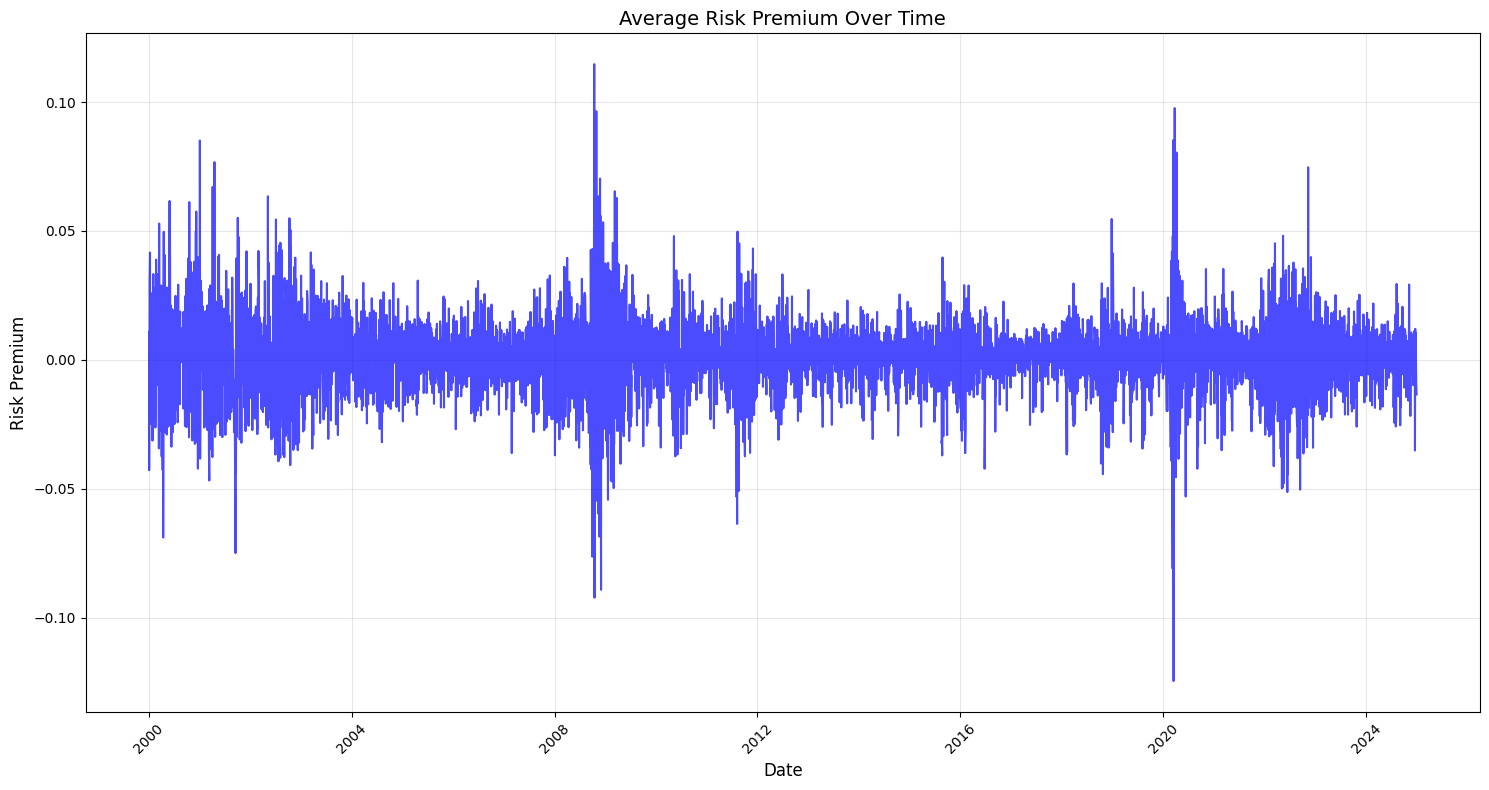

In [8]:
import matplotlib.pyplot as plt

# Set the style for better visualization
plt.style.use('default')  # using default matplotlib style

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Convert Date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Calculate mean risk premium for each date
daily_risk_premium = df.groupby('Date')['risk_premium'].mean()

# Create the plot
ax.plot(daily_risk_premium.index, daily_risk_premium.values, color='blue', alpha=0.7)

# Customize the plot
ax.set_title('Average Risk Premium Over Time', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Risk Premium', fontsize=12)
ax.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Export cleaned dataframe for ML and regression analysis

In [ ]:
# Drop the 'Unnamed: 0' column
df = df.drop('Unnamed: 0', axis=1)

df.to_csv("../data/cleaned_df_with_tickers.csv", index = False)


In [10]:
df.to_csv("../data/cleaned_df_with_tickers.csv", index = False)

In [11]:
df.drop("Ticker", axis=1, inplace=True)
print(df.shape)
df.to_csv("../data/cleaned_df.csv", index=False)

(504303, 74)


# Read in data of NDQ Stock Index Benchmark downloaded from Refinitiv

In [6]:
# Load NDQ100 data
file_path = '../data/nasdaq_100_benchmark.xlsx'
ndq_data = pd.read_excel(file_path, skiprows=32)
ndq_data

,Exchange Date,Close,Net,%Chg,Open,Low,High,Volume,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2024-12-31,21012.174,-184.915,-0.008724,21256.023,20979.519,21276.141,242351821,NaN,NaN,NaN,NaN,NaN
1,2024-12-30,21197.089,-275.926,-0.012850,21189.103,21046.632,21346.062,271327665,NaN,NaN,NaN,NaN,NaN
2,2024-12-27,21473.015,-295.297,-0.013565,21633.096,21292.194,21642.264,277846831,NaN,NaN,NaN,NaN,NaN
3,2024-12-26,21768.312,-29.339,-0.001346,21733.983,21645.617,21837.696,177996234,NaN,NaN,NaN,NaN,NaN
4,2024-12-24,21797.651,294.480,0.013695,21564.369,21558.966,21797.651,160062683,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,2012-01-09,2350.650,-5.520,-0.002343,2362.530,2342.340,2363.480,194726200,NaN,NaN,NaN,NaN,NaN
3266,2012-01-06,2356.170,7.190,0.003061,2350.680,2341.640,2362.580,183428720,NaN,NaN,NaN,NaN,NaN
3267,2012-01-05,2348.980,19.270,0.008271,2326.580,2317.520,2351.450,204583361,NaN,NaN,NaN,NaN,NaN
3268,2012-01-04,2329.710,7.750,0.003338,2316.530,2307.560,2333.290,201404142,NaN,NaN,NaN,NaN,NaN


In [1]:
import pandas as pd
import numpy as np

# Load and filter risk-free rate data
risk_free_file = "risk_free_rate.csv"
df_risk_free = pd.read_csv(risk_free_file)
df_risk_free['Date'] = pd.to_datetime(df_risk_free['Date'])
df_risk_free = df_risk_free[df_risk_free['Date'].dt.year >= 2012]  # Filter first
print("Risk-Free Rate Data Range:", df_risk_free['Date'].min(), "to", df_risk_free['Date'].max())

# Load and clean NDQ100 data
file_path = '../data/nasdaq_100_benchmark.xlsx'
ndq_data = pd.read_excel(file_path, skiprows=32)
ndq_data = ndq_data.dropna(axis=1, how='all')  # Only remove columns with ALL NaNs
print("\nNDQ100 Columns:", ndq_data.columns.tolist())

# Convert to datetime and sort
ndq_data['Exchange Date'] = pd.to_datetime(ndq_data['Exchange Date'])
ndq_data = ndq_data.sort_values('Exchange Date')

# Merge with filtered risk-free data
merged_data = pd.merge_asof(
    ndq_data,
    df_risk_free,
    left_on='Exchange Date',
    right_on='Date',
    direction='forward'  # Use forward fill for better alignment
)
print("\nMerged Data Sample:")
print(merged_data[['Exchange Date', 'Close', 'Risk_Free_Rate']].head())

# Calculate returns
merged_data['Return'] = merged_data['Close'].pct_change()
merged_data = merged_data.dropna(subset=['Return', 'Risk_Free_Rate'])

# Add time columns
merged_data['Year'] = merged_data['Exchange Date'].dt.year.astype(int)
merged_data['Month'] = merged_data['Exchange Date'].dt.month.astype(int)

# Monthly aggregation
monthly_returns = []
for year in merged_data['Year'].unique():
    year_data = merged_data[merged_data['Year'] == year]
    
    for month in range(1, 13):
        month_data = year_data[year_data['Month'] == month]
        if not month_data.empty:
            monthly_return = (1 + month_data['Return']).prod() - 1
            avg_risk_free = month_data['Risk_Free_Rate'].mean()
            
            monthly_returns.append({
                'Year': year,
                'Month': month,
                'Monthly Return': monthly_return,
                'Excess Return': monthly_return - avg_risk_free
            })

# Check for empty results
if not monthly_returns:
    raise ValueError("""
    No monthly returns calculated. Verify:
    1. Overlapping dates between NDQ100 and risk-free data
    2. 'Close' prices exist in NDQ data
    3. Valid risk-free rates for all trading days
    """)

monthly_df = pd.DataFrame(monthly_returns)

# Yearly aggregation
portfolio_returns = []
for year in monthly_df['Year'].unique():
    year_data = monthly_df[monthly_df['Year'] == year]
    
    yearly_cumulative = (1 + year_data['Monthly Return']).prod() - 1
    excess_returns = year_data['Excess Return']
    
    if excess_returns.std() > 0:
        sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    
    portfolio_returns.append({
        'Year': year,
        'Yearly Cumulative Return': yearly_cumulative,
        'Sharpe Ratio': sharpe_ratio
    })

final_results = pd.DataFrame(portfolio_returns)
print("\nFinal Results:\n", final_results)


Risk-Free Rate Data Range: 2012-01-02 00:00:00 to 2024-12-31 00:00:00

NDQ100 Columns: ['Exchange Date', 'Close', 'Net', '%Chg', 'Open', 'Low', 'High', 'Volume']

Merged Data Sample:
  Exchange Date    Close  Risk_Free_Rate
0    2012-01-03  2321.96    7.935718e-07
1    2012-01-04  2329.71    7.935718e-07
2    2012-01-05  2348.98    7.935718e-07
3    2012-01-06  2356.17    7.935718e-07
4    2012-01-09  2350.65    3.968056e-07

Final Results:
     Year  Yearly Cumulative Return  Sharpe Ratio
0   2012                  0.145984      0.973403
1   2013                  0.349902      3.656941
2   2014                  0.179366      1.666991
3   2015                  0.084270      0.553275
4   2016                  0.058858      0.467998
5   2017                  0.315157      3.618870
6   2018                 -0.010390      0.025731
7   2019                  0.379640      2.128997
8   2020                  0.475802      1.630990
9   2021                  0.266273      1.904235
10  2022       

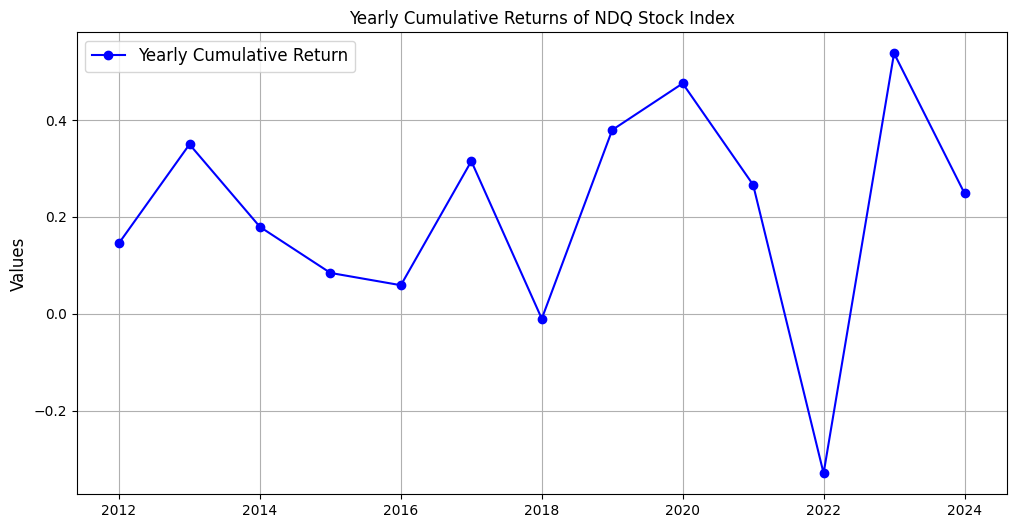

In [3]:
import matplotlib.pyplot as plt

# Plotting cumulative returns and Sharpe ratios
plt.figure(figsize=(12, 6))

# Plot Yearly Cumulative Returns
plt.plot(final_results['Year'], final_results['Yearly Cumulative Return'], marker='o', label='Yearly Cumulative Return', color='blue')

# Add labels, title, and legend
plt.title('Yearly Cumulative Returns of NDQ Stock Index')
plt.ylabel('Values', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [4]:
final_results.to_csv("benchmark_portfolio_performance.csv")

# Visualisations

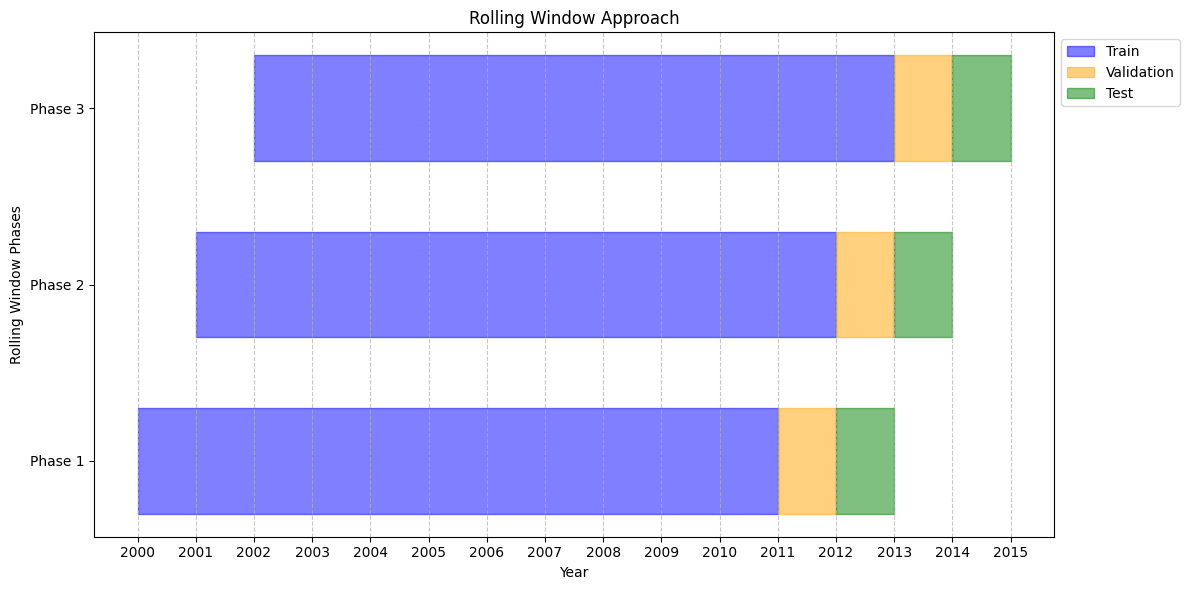

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the rolling window phases
phases = [
    {"Train": (2000, 2011), "Validation": (2011, 2012), "Test": (2012, 2013)},
    {"Train": (2001, 2012), "Validation": (2012, 2013), "Test": (2013, 2014)},
    {"Train": (2002, 2013), "Validation": (2013, 2014), "Test": (2014, 2015)},
]

# Create the visualization
plt.figure(figsize=(12, 6))

# Determine the full range of years to display on the x-axis
all_years = range(2000, 2016)

for i, phase in enumerate(phases):
    train_start, train_end = phase["Train"]
    validation_start, validation_end = phase["Validation"]
    test_start, test_end = phase["Test"]

    # Plot the train period as a box
    plt.fill_between(
        range(train_start, train_end + 1),
        [i - 0.3] * (train_end - train_start + 1),
        [i + 0.3] * (train_end - train_start + 1),
        label="Train" if i == 0 else None,
        color="blue",
        alpha=0.5,
    )

    # Plot the validation period as a box spanning the range
    plt.fill_between(
        range(validation_start, validation_end + 1),
        [i - 0.3],
        [i + 0.3],
        label="Validation" if i == 0 else None,
        color="orange",
        alpha=0.5,
    )

    # Plot the test period as a box spanning the range
    plt.fill_between(
        range(test_start, test_end + 1),
        [i - 0.3],
        [i + 0.3],
        label="Test" if i == 0 else None,
        color="green",
        alpha=0.5,
    )

# Add labels and legend
plt.xticks(all_years)  # Show all years on the x-axis
plt.yticks(range(len(phases)), [f"Phase {i + 1}" for i in range(len(phases))])
plt.xlabel("Year")
plt.ylabel("Rolling Window Phases")
plt.title("Rolling Window Approach")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()